# εισαγουμε τις βιβλιοθηκες και τα δεδομενα

In [1]:
import catboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit,train_test_split,GridSearchCV

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df_url='C:/Users/User/Desktop/energy_dataset.csv'
df=pd.read_csv(df_url)
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


# περνουμε πληροφοριες για το dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
# αφαιρουμε τις κενές στήλες του dataset
df=df.drop(['generation fossil coal-derived gas'], axis = 1)
df=df.drop(['generation fossil oil shale'], axis = 1)
df=df.drop(['generation fossil peat'], axis = 1)
df=df.drop(['generation geothermal'], axis = 1)
df=df.drop(['generation hydro pumped storage aggregated'], axis = 1)
df=df.drop(['generation marine'], axis = 1)
df=df.drop(['generation wind offshore'], axis = 1)
# αφαιρουμε τις προβλεψεις του dataset
df=df.drop(['forecast solar day ahead'], axis = 1)
df=df.drop(['forecast wind offshore eday ahead'], axis = 1)
df=df.drop(['forecast wind onshore day ahead'], axis = 1)
df=df.drop(['total load forecast'], axis = 1)
df=df.drop(['price day ahead'], axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [5]:
df.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,116.80


# βλεπουμε αν το dataset εχει μηδενικες τιμες ή διπλοεγγραφες 

In [6]:
print('There are {} missing values or NaNs in df.'.format(df.isnull().values.sum()))
temp_energy = df.duplicated(keep='first').sum()

print('There are {} duplicate rows in df.'.format(temp_energy))

There are 292 missing values or NaNs in df.
There are 0 duplicate rows in df.


In [7]:
# Find the number of NaNs in each column
df.isnull().sum(axis=0)

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price actual                                    0
dtype: int64

In [8]:
# Display τις τελευαιες γραμμες με μηδενικα

df[df.isnull().any(axis=1)].tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
16612,2016-11-23 04:00:00+01:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,23112.0,49.11
25164,2017-11-14 12:00:00+01:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,66.17
25171,2017-11-14 19:00:00+01:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,75.45
30185,2018-06-11 18:00:00+02:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,NaN,64.93
30896,2018-07-11 09:00:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.79


# χειριζομαστε τις μηδενικες τιμες με γραμμικη παρεμβολη

In [9]:
# Fill null values using interpolation

df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

# βλεπουμε τις συσχετισεις μεταξυ των μεταβλητων

In [10]:
# Correlation Matrix

Corr_Matrix = df.corr(method='pearson')
print(Corr_Matrix['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
generation waste                               0.168710
generation biomass                             0.142671
generation other                               0.099914
generation solar                               0.098529
generation hydro water reservoir               0.071910
generation nuclear                            -0.053016
generation hydro run-of-river and poundage    -0.136659
generation wind onshore                       -0.220497
generation hydro pumped storage consumption   -0.426196


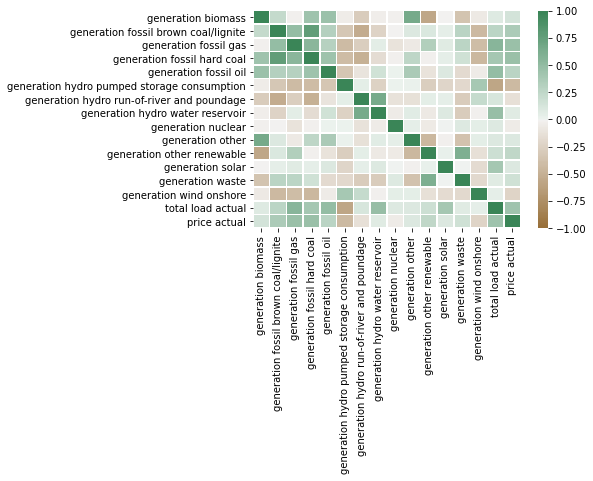

In [11]:
correlation_full_health = df.corr()
axis_corr = sns.heatmap(
correlation_full_health,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
linewidths=0.6)
plt.show()


# σχεδιαγραμματα για την κατανοηση των τιμων σε καθε στηλη

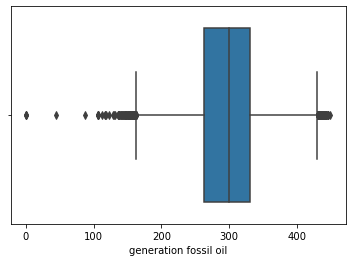

In [12]:
sns.boxplot(x=df['generation fossil oil'])
plt.show()

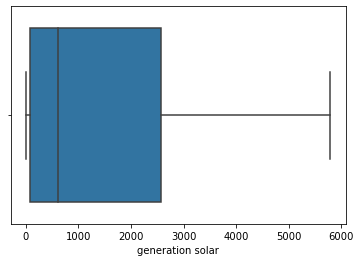

In [13]:
sns.boxplot(x=df['generation solar'])
plt.show()

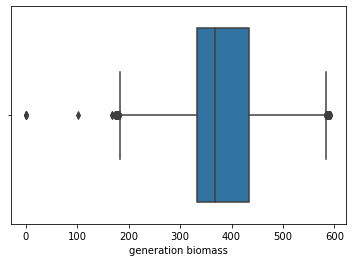

In [14]:
sns.boxplot(x=df['generation biomass'])
plt.show()

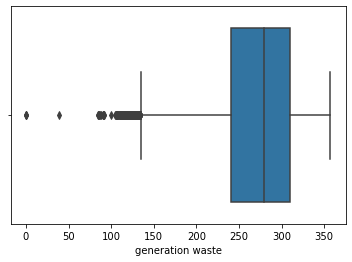

In [15]:
sns.boxplot(x=df['generation waste'])
plt.show()

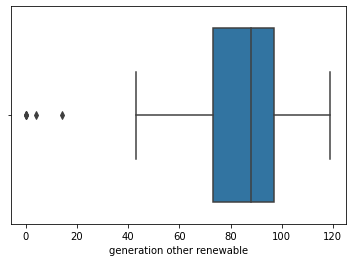

In [16]:
sns.boxplot(x=df['generation other renewable'])
plt.show()

# μετατροπη του χρονου σε datetime value

In [17]:
#df['time'] = pd.to_datetime(df['time'], format = '%Y/%m/%d', errors = 'coerce')
#df['time'] = pd.to_datetime(df['time'], utc=True).dt.normalize()
df['time'] = pd.to_datetime(df['time'], utc=True, infer_datetime_format=True)
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,56.04


# δημιουργια νεου dataset

In [18]:
def create_datetime(new_df): 
    """
    Creates time series features from datetime index
    
    """
    new_df['Year'] = new_df['time'].dt.year
    new_df['Month'] =new_df['time'].dt.month
    new_df['Day'] = new_df['time'].dt.day
    new_df['Hour'] = new_df['time'].dt.hour
    
    return new_df

create_datetime(df)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,Year,Month,Day,Hour
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,73.0,49.0,196.0,6378.0,25385.0,65.41,2014,12,31,23
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,71.0,50.0,195.0,5890.0,24382.0,64.92,2015,1,1,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,73.0,50.0,196.0,5461.0,22734.0,64.48,2015,1,1,1
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,75.0,50.0,191.0,5238.0,21286.0,59.32,2015,1,1,2
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,74.0,42.0,189.0,4935.0,20264.0,56.04,2015,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,95.0,85.0,277.0,3113.0,30653.0,77.02,2018,12,31,18
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,95.0,33.0,280.0,3288.0,29735.0,76.16,2018,12,31,19
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,94.0,31.0,286.0,3503.0,28071.0,74.30,2018,12,31,20
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,93.0,31.0,287.0,3586.0,25801.0,69.89,2018,12,31,21


# Δημιουργια εποχων

In [19]:
def create_Epochs(df):
    winter = (df.Month>=1)&(df.Month<=3)
    spring = (df.Month>=4)&(df.Month<=6)
    summer = (df.Month>=7)&(df.Month<=9)
    automn = (df.Month>=10)@(df.Month<=12)
    
    # Create column in dataframe that inputs the season based on the conditions created above
    df['season'] = np.where(winter,'winter',
                   np.where(spring,'spring',
                   np.where(summer,'summer',
                   np.where(automn,'automn',np.nan))))

    return df
    

create_Epochs(df)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,Year,Month,Day,Hour,season
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,49.0,196.0,6378.0,25385.0,65.41,2014,12,31,23,automn
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,50.0,195.0,5890.0,24382.0,64.92,2015,1,1,0,winter
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,50.0,196.0,5461.0,22734.0,64.48,2015,1,1,1,winter
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,50.0,191.0,5238.0,21286.0,59.32,2015,1,1,2,winter
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,42.0,189.0,4935.0,20264.0,56.04,2015,1,1,3,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,85.0,277.0,3113.0,30653.0,77.02,2018,12,31,18,automn
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,33.0,280.0,3288.0,29735.0,76.16,2018,12,31,19,automn
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,31.0,286.0,3503.0,28071.0,74.30,2018,12,31,20,automn
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,31.0,287.0,3586.0,25801.0,69.89,2018,12,31,21,automn


In [20]:
clist = ['Year','Month','Day','Hour','generation biomass','generation fossil brown coal/lignite','generation fossil gas','generation fossil hard coal','generation fossil oil','generation hydro pumped storage consumption',
         'generation hydro run-of-river and poundage','generation hydro water reservoir','generation nuclear',
         'generation other','generation other renewable','generation solar',
         'generation waste','generation wind onshore','price actual']
         #'total load actual'για την ωρα δεν το χρησιμοποιουμε
df2= df[clist]
df2

,Year,Month,Day,Hour,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,price actual
0,2014,12,31,23,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,65.41
1,2015,1,1,0,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,64.92
2,2015,1,1,1,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,64.48
3,2015,1,1,2,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,59.32
4,2015,1,1,3,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018,12,31,18,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,77.02
35060,2018,12,31,19,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,76.16
35061,2018,12,31,20,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,74.30
35062,2018,12,31,21,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,93.0,31.0,287.0,3586.0,69.89


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Year                                         35064 non-null  int64  
 1   Month                                        35064 non-null  int64  
 2   Day                                          35064 non-null  int64  
 3   Hour                                         35064 non-null  int64  
 4   generation biomass                           35064 non-null  float64
 5   generation fossil brown coal/lignite         35064 non-null  float64
 6   generation fossil gas                        35064 non-null  float64
 7   generation fossil hard coal                  35064 non-null  float64
 8   generation fossil oil                        35064 non-null  float64
 9   generation hydro pumped storage consumption  35064 non-null  float64
 10

# Brake dataset from years

In [22]:
#howManyYears=pd.unique(df2["Year"])
#howManyYears

In [23]:
#newDataForTrain=df2.loc[df2['Year'] != 2018]
#newDataForTrain.info()

# Brake dataset με τιμες

In [24]:
newDataForTrain=df2.iloc[-2000:]
newDataForTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 33064 to 35063
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Year                                         2000 non-null   int64  
 1   Month                                        2000 non-null   int64  
 2   Day                                          2000 non-null   int64  
 3   Hour                                         2000 non-null   int64  
 4   generation biomass                           2000 non-null   float64
 5   generation fossil brown coal/lignite         2000 non-null   float64
 6   generation fossil gas                        2000 non-null   float64
 7   generation fossil hard coal                  2000 non-null   float64
 8   generation fossil oil                        2000 non-null   float64
 9   generation hydro pumped storage consumption  2000 non-null   float64


# δημιουργια dataset για το test

In [25]:
#newDataForTest=df2.loc[df2['Year'] == 2018]
newDataForTest=df2.iloc[0:33064]
#clist = ['Year','Month','Day','Hour','generation biomass','generation fossil brown coal/lignite','generation fossil gas','generation fossil hard coal','generation fossil oil','generation hydro pumped storage consumption',
#         'generation hydro run-of-river and poundage','generation hydro water reservoir','generation nuclear',
#         'generation other','generation other renewable','generation solar',
#         'generation waste','generation wind onshore']
#newDataForTest= newDataForTest[clist]
newDataForTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33064 entries, 0 to 33063
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Year                                         33064 non-null  int64  
 1   Month                                        33064 non-null  int64  
 2   Day                                          33064 non-null  int64  
 3   Hour                                         33064 non-null  int64  
 4   generation biomass                           33064 non-null  float64
 5   generation fossil brown coal/lignite         33064 non-null  float64
 6   generation fossil gas                        33064 non-null  float64
 7   generation fossil hard coal                  33064 non-null  float64
 8   generation fossil oil                        33064 non-null  float64
 9   generation hydro pumped storage consumption  33064 non-null  float64
 10

In [26]:
newDataForTest

,Year,Month,Day,Hour,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,price actual
0,2014,12,31,23,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,65.41
1,2015,1,1,0,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,64.92
2,2015,1,1,1,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,64.48
3,2015,1,1,2,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,59.32
4,2015,1,1,3,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33059,2018,10,9,10,359.0,760.0,6777.0,4957.0,315.0,0.0,870.0,2500.0,6957.0,57.0,105.0,4468.0,328.0,1610.0,77.30
33060,2018,10,9,11,358.0,760.0,6860.0,4988.0,314.0,0.0,881.0,2702.0,6932.0,58.0,108.0,4747.0,329.0,1573.0,76.17
33061,2018,10,9,12,364.0,760.0,6796.0,5000.0,312.0,0.0,879.0,2352.0,6935.0,57.0,107.0,4909.0,319.0,1596.0,72.90
33062,2018,10,9,13,366.0,761.0,6673.0,4973.0,312.0,0.0,840.0,2175.0,6932.0,57.0,107.0,4755.0,314.0,1880.0,72.46


In [27]:
newDataForTrain.to_csv(r'C:\Users\User\Desktop\project\Energy_Dataset_Test.csv')

# προετοιμασια των δεδομενων για το test

In [28]:
features = list(newDataForTest.columns[1:18]) #we take the features that we want to use for the prediction
features

['Month',
 'Day',
 'Hour',
 'generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore']

In [29]:
X= newDataForTest[features] #we use as the x value the features
y = newDataForTest['price actual']

In [30]:
#use 80 % of the model to train and the 20% to test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

# βρισκουμαι τις καταλληλες παραμετρους για το μοντελο

In [31]:
#model_CBR = CatBoostRegressor()

In [32]:
#parameters = {'depth'         : [5,10,15,15],
#              'learning_rate' : [1,1,1,1],
#              'iterations'    : [800,1000,1500,2000]}

In [33]:
#grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
#grid.fit(X_train, y_train)

In [34]:
#print(" Results from Grid Search " )
#print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
#print("\n The best score across ALL searched params:\n", grid.best_score_)
#print("\n The best parameters across ALL searched params:\n", grid.best_params_)

# εκπαιδευουμε το μοντελο

In [35]:
rf =CatBoostRegressor(iterations=1000 ,depth=10,random_seed=42)
rf.fit(X_train,y_train)

Learning rate set to 0.068695
0:	learn: 13.7317800	total: 251ms	remaining: 4m 11s
1:	learn: 13.2609337	total: 329ms	remaining: 2m 44s
2:	learn: 12.8093573	total: 399ms	remaining: 2m 12s
3:	learn: 12.4028295	total: 471ms	remaining: 1m 57s
4:	learn: 12.0186897	total: 544ms	remaining: 1m 48s
5:	learn: 11.6708170	total: 616ms	remaining: 1m 42s
6:	learn: 11.3210599	total: 687ms	remaining: 1m 37s
7:	learn: 11.0294030	total: 741ms	remaining: 1m 31s
8:	learn: 10.7117997	total: 794ms	remaining: 1m 27s
9:	learn: 10.4362490	total: 847ms	remaining: 1m 23s
10:	learn: 10.1787974	total: 899ms	remaining: 1m 20s
11:	learn: 9.9243319	total: 945ms	remaining: 1m 17s
12:	learn: 9.6745110	total: 990ms	remaining: 1m 15s
13:	learn: 9.4659536	total: 1.03s	remaining: 1m 12s
14:	learn: 9.2733104	total: 1.08s	remaining: 1m 10s
15:	learn: 9.1079809	total: 1.12s	remaining: 1m 9s
16:	learn: 8.9456217	total: 1.17s	remaining: 1m 7s
17:	learn: 8.8002134	total: 1.21s	remaining: 1m 6s
18:	learn: 8.6379932	total: 1.26s	re

# ελεγχουμε τα αποτελεσματα της εκπαιδευσης του αλγοριθμου

In [36]:
score = rf.score(X_test, y_test)
Y_pred = rf.predict(X_test)#.round()

#Y_pred

In [37]:
errors = abs(Y_pred - y_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, Y_pred)), '.3f'))
MSE = mean_squared_error(y_test, Y_pred)
MAE = mean_absolute_error(y_test, Y_pred)
R2 = r2_score(y_test, Y_pred, multioutput='variance_weighted')

print('Average absolute error:', round(np.mean(errors), 2))
print("Root Mean Squared Error (RMSE): ", RMSE)
print("Mean Squared Error (MSE): ", MSE)
print("Mean Absolute Error (MAE): ", MAE)
print("R2_Score: ", R2)
print('Score: ',score.round(2))

Average absolute error: 2.25
Root Mean Squared Error (RMSE):  3.176
Mean Squared Error (MSE):  10.088313747049797
Mean Absolute Error (MAE):  2.2512059834040885
R2_Score:  0.9509986486229614
Score:  0.95


In [38]:
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Month                Importance: 18.39
Variable: Day                  Importance: 11.54
Variable: generation other renewable Importance: 9.09
Variable: generation fossil hard coal Importance: 7.86
Variable: generation nuclear   Importance: 7.71
Variable: generation fossil gas Importance: 6.53
Variable: Hour                 Importance: 6.33
Variable: generation hydro run-of-river and poundage Importance: 6.16
Variable: generation other     Importance: 4.08
Variable: generation biomass   Importance: 3.88
Variable: generation waste     Importance: 3.64
Variable: generation fossil oil Importance: 3.37
Variable: generation hydro water reservoir Importance: 3.17
Variable: generation hydro pumped storage consumption Importance: 2.41
Variable: generation wind onshore Importance: 2.3
Variable: generation fossil brown coal/lignite Importance: 2.22
Variable: generation solar     Importance: 1.32


In [39]:
y_test=y_test.reset_index(drop=True)

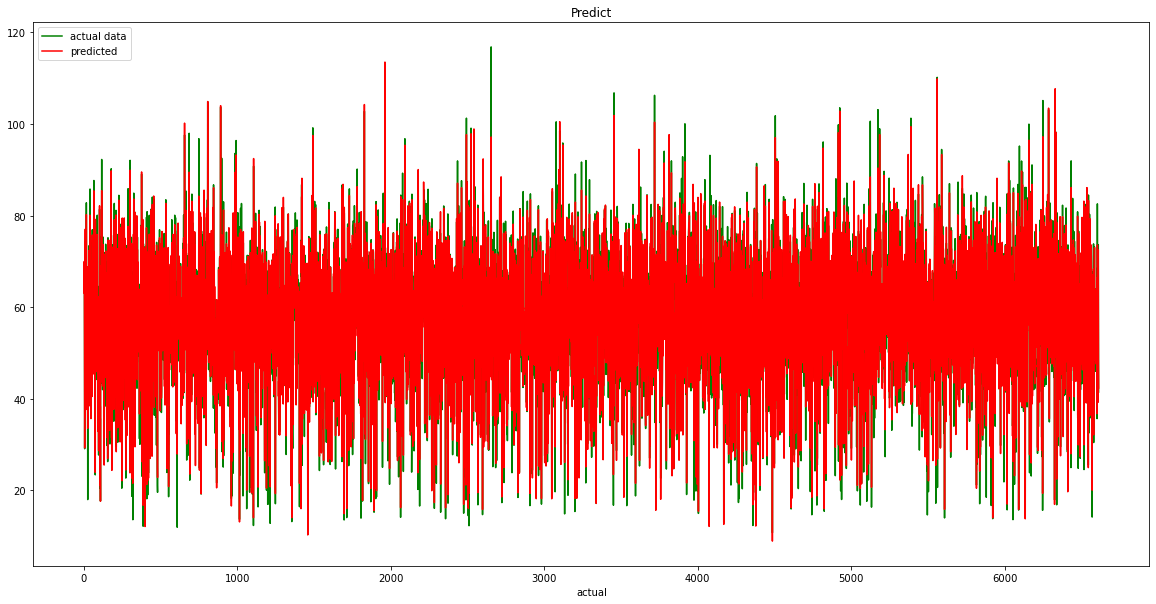

In [40]:
plt_title = 'Predict'
fig_verify = plt.figure(figsize=(20, 10))
plt.plot(y_test, color="green")
plt.plot(Y_pred,color="red")
plt.title('prediction')
plt.xlabel('actual')
plt.legend(['actual data','predicted'], loc='upper left')
plt.title(plt_title)
plt.show()

# αποθηκεουμε το εκπαιδευμενο μοντελο και να χρησιμοποιησουμε ξανα

In [41]:
import joblib
joblib.dump(rf, "New_predict_energy.joblib")

['New_predict_energy.joblib']

In [42]:
new_predict=joblib.load("New_predict_energy.joblib")

# περνω την τελευταια γραμμη του 2018 απλα για τεστ

In [43]:
last_value=df2.tail(1) 
last_value

,Year,Month,Day,Hour,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,price actual
35063,2018,12,31,22,290.0,0.0,6926.0,2166.0,163.0,108.0,1069.0,1686.0,6075.0,61.0,92.0,31.0,287.0,3651.0,69.88


In [44]:
new_predict.predict(last_value)

array([70.01351935])